In [455]:
import pandas as pd

In [456]:
data = pd.read_csv('../Data/epsPQRS.csv', sep=';')
data

,Comentario,Area
0,pqrd-18-0674823nurc 1-2018-221502entidad: capi...,Otro
1,pqrd-18-0675272nurc 1-2018-216612entidad: capi...,Oportunidad Citas Red Contratada
2,pqrd-18-0675410nurc 1-2018-221583entidad: capi...,Dificultad Accesibilidad Administrativa
3,pqrd-18-0675530nurc 1-2018-217812entidad: capi...,Otro
4,favor enviar copia al ministerio de salud y pr...,Otro
...,...,...
77821,ss vacunas antigeno del virus de hepatitis b 2...,No Suministro Medicamentos
77822,apixaban 5 mg tableta,No Suministro Medicamentos
77823,ss solucion mipres 20201123175024488426,Negación De ServiciosDificultad MédicoAdmin
77824,ss implante de dispositivo en cornea asistido,Negación De ServiciosDificultad MédicoAdmin


In [457]:
#data = data.sample(frac=0.85)

In [458]:
data.Area.value_counts(normalize=True)

Oportunidad Citas Red Contratada                  0.456428
No Suministro Medicamentos                        0.183152
Dificultad Accesibilidad Administrativa           0.128941
Otro                                              0.101855
Inconsistencias Sistemas De InformacionAsegura    0.075309
Negación De ServiciosDificultad MédicoAdmin       0.054313
Name: Area, dtype: float64

In [459]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.3)

In [460]:
print(f'Tenemos {data.shape[0]} datos en total.')
print(f'El conjunto de entrenamiento (train) tiene {train.shape[0]} datos.')
print(f'El conjunto de prueba (test) tiene {test.shape[0]} datos.')

Tenemos 77826 datos en total.
El conjunto de entrenamiento (train) tiene 54478 datos.
El conjunto de prueba (test) tiene 23348 datos.


In [461]:
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
#nltk.download('stopwords')
stopwords_sp = stopwords.words('spanish')

In [462]:
stopwords_sp.extend(["pqrd", "entidad", "nurc", "dia", "capital", "salud","bogotá"])
def pre_procesado(texto):
    texto = texto.lower()
    texto = re.sub(r"[\W\d_]+", " ", texto)
    texto = texto.split() # Tokenizar
    texto = [palabra for palabra in texto if palabra not in stopwords_sp]
    texto = " ".join(texto)
    return texto

tfidf_vect = TfidfVectorizer(preprocessor=pre_procesado)

In [463]:
X_train = tfidf_vect.fit_transform(train.Comentario.values)
y_train = train.Area.values

In [464]:
X_test = tfidf_vect.transform(test.Comentario.values)
y_test = test.Area.values

In [465]:
print(f"Tamaño de X_train (entrenamiento): {pd.DataFrame(X_train.toarray()).shape}")

MemoryError: Unable to allocate 21.4 GiB for an array with shape (54478, 52727) and data type float64

In [466]:
print(f"Tamaño de X_test (prueba): {pd.DataFrame(X_test.toarray()).shape}")

Tamaño de X_test (prueba): (23348, 52727)


In [467]:
print(f"Tamaño de y_train {len(y_train)} y tamaño de y_test {len(y_test)}")

Tamaño de y_train 54478 y tamaño de y_test 23348


# Modelos

In [468]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler

import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

In [469]:
solicitud = ['diagnóstico posible derrame interno se encuentra hospitalizado en la ips hospital de san jorge',
             'Tengo mucho dolor de cabeza y necesito atencion', 
             'Estoy solicitando una cita desde hace mucho tiempo']
solicitud_trans = tfidf_vect.transform(solicitud)

# Naive Bayes

In [470]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [471]:
nb.fit(X_train, y_train)

MultinomialNB()

In [472]:
y_pred_nb = nb.predict(X_test)

In [473]:
print( f'Exactitud: {accuracy_score(y_test, y_pred_nb):>15.2f}')

Exactitud:            0.64


In [474]:
print(classification_report(y_test, y_pred_nb))

                                                precision    recall  f1-score   support

       Dificultad Accesibilidad Administrativa       0.65      0.32      0.43      3042
Inconsistencias Sistemas De InformacionAsegura       0.93      0.37      0.53      1746
   Negación De ServiciosDificultad MédicoAdmin       0.85      0.05      0.09      1241
                    No Suministro Medicamentos       0.74      0.60      0.66      4282
              Oportunidad Citas Red Contratada       0.60      0.97      0.74     10720
                                          Otro       0.65      0.09      0.16      2317

                                      accuracy                           0.64     23348
                                     macro avg       0.74      0.40      0.43     23348
                                  weighted avg       0.68      0.64      0.58     23348



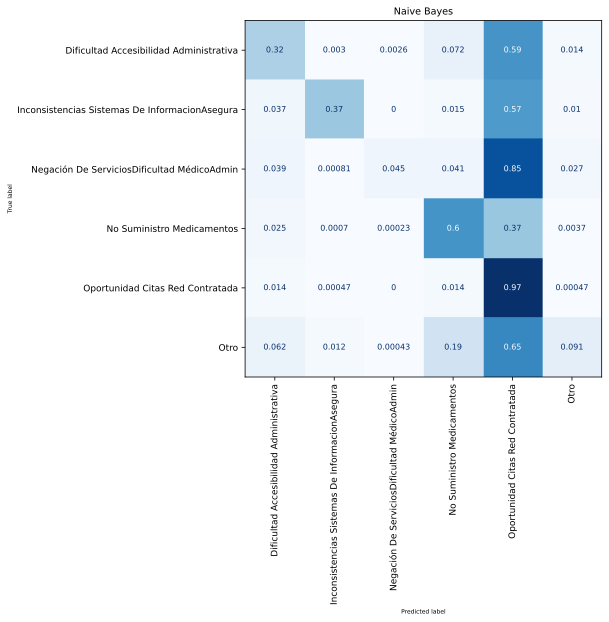

In [475]:
%config InlineBackend.figure_format = 'svg'
fig, ax = plt.subplots(figsize = (8, 8))

# Set general font size
plt.rcParams['font.size'] = '8'

plot_confusion_matrix(nb, X_test, y_test, cmap="Blues", ax=ax, normalize='true').im_.colorbar.remove()
plt.xticks(rotation=90, fontsize=9)
plt.yticks(fontsize=9)
plt.title("Naive Bayes")
plt.show()

In [476]:
print(nb.predict(solicitud_trans))

['Oportunidad Citas Red Contratada' 'Oportunidad Citas Red Contratada'
 'Oportunidad Citas Red Contratada']


# Regresión Logística

In [477]:
us = NearMiss(sampling_strategy={}, n_neighbors=3, version=2)
X_train_res, y_train_res = us.fit_resample(X_train, y_train)

In [478]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression() # class_weight='balanced', C=1.0,penalty='l2',random_state=1,solver="newton-cg"

In [479]:
logreg.fit(X_train_res, y_train_res)

C:\Users\jrm20\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [480]:
y_pred_logreg = logreg.predict(X_test)

In [481]:
print( f'Exactitud: {accuracy_score(y_test, y_pred_logreg):>15.2f}')

Exactitud:            0.75


In [482]:
print(classification_report(y_test, y_pred_logreg))

                                                precision    recall  f1-score   support

       Dificultad Accesibilidad Administrativa       0.62      0.49      0.55      3042
Inconsistencias Sistemas De InformacionAsegura       0.85      0.77      0.81      1746
   Negación De ServiciosDificultad MédicoAdmin       0.62      0.40      0.49      1241
                    No Suministro Medicamentos       0.75      0.77      0.76      4282
              Oportunidad Citas Red Contratada       0.80      0.93      0.86     10720
                                          Otro       0.55      0.41      0.47      2317

                                      accuracy                           0.75     23348
                                     macro avg       0.70      0.63      0.66     23348
                                  weighted avg       0.74      0.75      0.74     23348



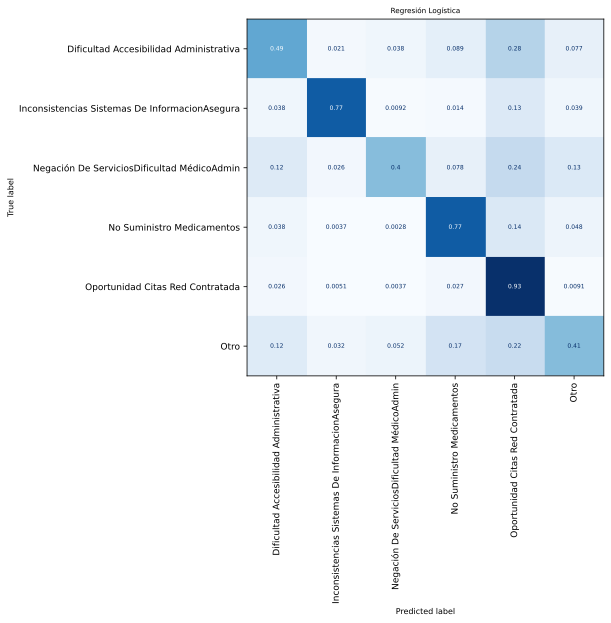

In [483]:
%config InlineBackend.figure_format = 'svg'
fig, ax = plt.subplots(figsize = (8, 8))

# Set general font size
plt.rcParams['font.size'] = '6'

plot_confusion_matrix(logreg, X_test, y_test, cmap="Blues", ax=ax, normalize='true').im_.colorbar.remove()
plt.xticks(rotation=90, fontsize=9)
plt.yticks(fontsize=9)
plt.title("Regresión Logística")
plt.show()

In [484]:
print(logreg.predict(solicitud_trans))

['Negación De ServiciosDificultad MédicoAdmin'
 'Oportunidad Citas Red Contratada' 'Oportunidad Citas Red Contratada']


# Árbol de decisión

In [485]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(class_weight='balanced')

In [486]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced')

In [487]:
y_pred_dt = dt.predict(X_test)

In [488]:
print( f'Exactitud: {accuracy_score(y_test, y_pred_dt):>15.2f}')

Exactitud:            0.64


In [489]:
print(classification_report(y_test, y_pred_dt))

                                                precision    recall  f1-score   support

       Dificultad Accesibilidad Administrativa       0.47      0.47      0.47      3042
Inconsistencias Sistemas De InformacionAsegura       0.65      0.68      0.66      1746
   Negación De ServiciosDificultad MédicoAdmin       0.33      0.39      0.35      1241
                    No Suministro Medicamentos       0.66      0.64      0.65      4282
              Oportunidad Citas Red Contratada       0.81      0.77      0.79     10720
                                          Otro       0.34      0.40      0.36      2317

                                      accuracy                           0.64     23348
                                     macro avg       0.54      0.56      0.55     23348
                                  weighted avg       0.66      0.64      0.65     23348



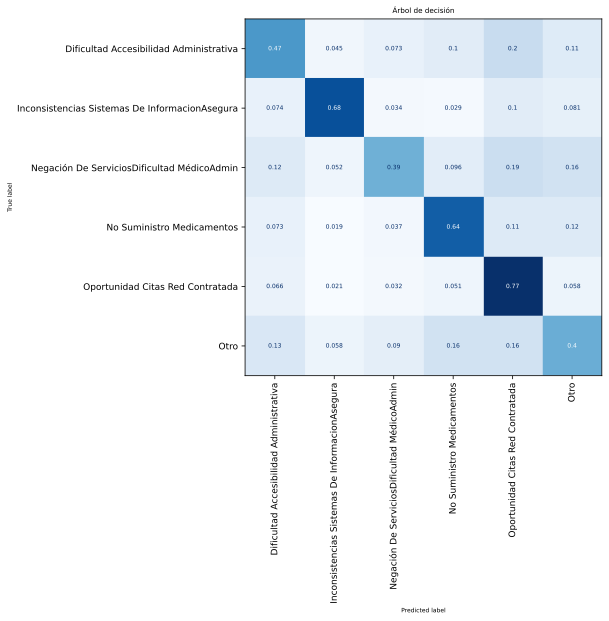

In [490]:
%config InlineBackend.figure_format = 'svg'
fig, ax = plt.subplots(figsize = (8, 8))

# Set general font size
plt.rcParams['font.size'] = '6'

plot_confusion_matrix(dt, X_test, y_test, cmap="Blues", ax=ax, normalize='true').im_.colorbar.remove()
plt.xticks(rotation=90, fontsize=9)
plt.yticks(fontsize=9)
plt.title("Árbol de decisión")
plt.show()

In [491]:
print(dt.predict(solicitud_trans))

['Negación De ServiciosDificultad MédicoAdmin'
 'Oportunidad Citas Red Contratada' 'Oportunidad Citas Red Contratada']


# Red Neuronal

In [319]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='adam', alpha=1e-5, activation='logistic', max_iter=100,hidden_layer_sizes=(20,30), random_state=1)

In [320]:
clf.fit(X_train, y_train)

C:\Users\jrm20\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='logistic', alpha=1e-05, hidden_layer_sizes=(20, 30),
              max_iter=100, random_state=1)

In [321]:
y_pred_clf = clf.predict(X_test)

In [322]:
print( f'Exactitud: {accuracy_score(y_test, y_pred_clf):>15.2f}')

Exactitud:            0.66


In [323]:
print(classification_report(y_test, y_pred_clf))

                                                precision    recall  f1-score   support

       Dificultad Accesibilidad Administrativa       0.48      0.50      0.49      2539
Inconsistencias Sistemas De InformacionAsegura       0.64      0.68      0.66      1467
   Negación De ServiciosDificultad MédicoAdmin       0.42      0.34      0.37      1070
                    No Suministro Medicamentos       0.63      0.62      0.63      3655
              Oportunidad Citas Red Contratada       0.80      0.82      0.81      9098
                                          Otro       0.39      0.36      0.37      2017

                                      accuracy                           0.66     19846
                                     macro avg       0.56      0.55      0.56     19846
                                  weighted avg       0.65      0.66      0.66     19846



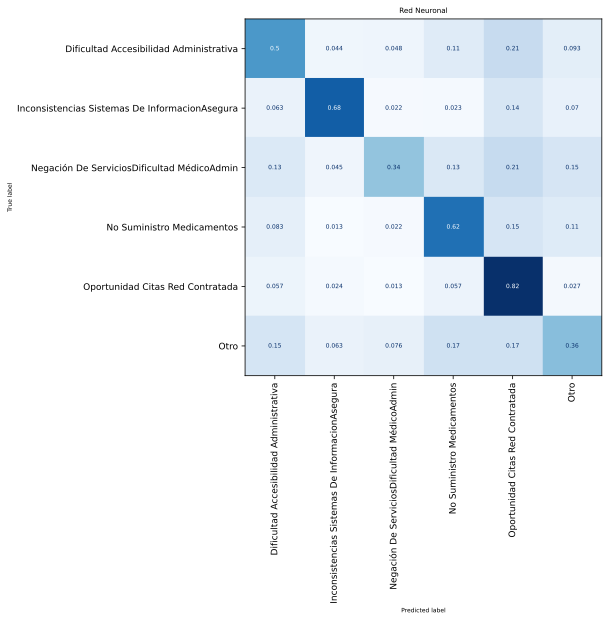

In [324]:
%config InlineBackend.figure_format = 'svg'
fig, ax = plt.subplots(figsize = (8, 8))

# Set general font size
plt.rcParams['font.size'] = '6'

plot_confusion_matrix(clf, X_test, y_test, cmap="Blues", ax=ax, normalize='true').im_.colorbar.remove()
plt.xticks(rotation=90, fontsize=9)
plt.yticks(fontsize=9)
plt.title("Red Neuronal")
plt.show()

In [164]:
clf.predict(solicitud_trans)

array(['Negación De Servicios', 'Dificultad Accesibilidad Administrativa',
       'Oportunidad Citas Red Contratada'], dtype='<U46')

# SVM

In [492]:
sampling_strategy = {}
us = NearMiss(sampling_strategy=sampling_strategy, n_neighbors=3, version=2)
X_train_res, y_train_res = us.fit_resample(X_train, y_train)

In [493]:
from sklearn.svm import LinearSVC
svm = LinearSVC()

In [494]:
svm.fit(X_train_res, y_train_res)

LinearSVC()

In [495]:
y_pred_svm = svm.predict(X_test)

In [496]:
print( f'Exactitud: {accuracy_score(y_test, y_pred_svm):>15.2f}')

Exactitud:            0.75


In [497]:
print(classification_report(y_test, y_pred_svm))

                                                precision    recall  f1-score   support

       Dificultad Accesibilidad Administrativa       0.61      0.50      0.55      3042
Inconsistencias Sistemas De InformacionAsegura       0.82      0.79      0.81      1746
   Negación De ServiciosDificultad MédicoAdmin       0.56      0.41      0.47      1241
                    No Suministro Medicamentos       0.73      0.77      0.75      4282
              Oportunidad Citas Red Contratada       0.82      0.91      0.86     10720
                                          Otro       0.52      0.42      0.47      2317

                                      accuracy                           0.75     23348
                                     macro avg       0.68      0.64      0.65     23348
                                  weighted avg       0.73      0.75      0.74     23348



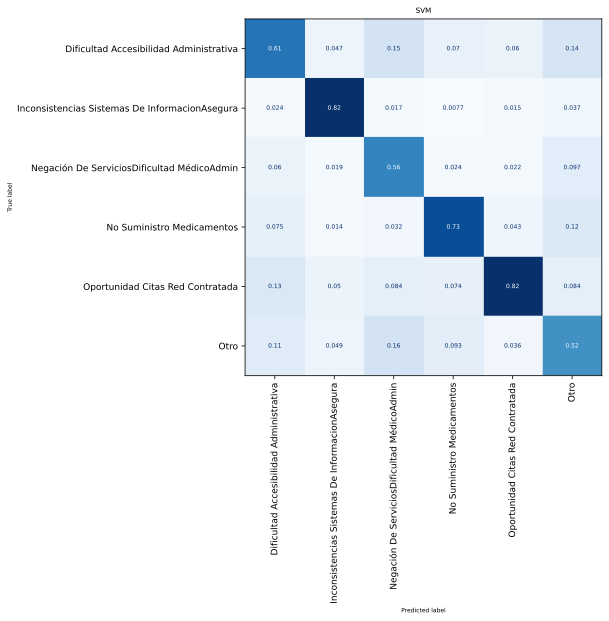

In [498]:
%config InlineBackend.figure_format = 'svg'
fig, ax = plt.subplots(figsize = (8, 8))

# Set general font size
plt.rcParams['font.size'] = '6'

plot_confusion_matrix(svm, X_test, y_test, cmap="Blues", ax=ax, normalize='pred').im_.colorbar.remove()
plt.xticks(rotation=90, fontsize=9)
plt.yticks(fontsize=9)
plt.title("SVM")
plt.show()

In [499]:
print(svm.predict(solicitud_trans))

['Negación De ServiciosDificultad MédicoAdmin'
 'Oportunidad Citas Red Contratada' 'Oportunidad Citas Red Contratada']
